In [5]:
import pandas as pd
import datetime
from dateutil import parser
import numpy as np
import json
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import pytz
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Exercise

In this exercise we imagine you are working as the data analyst on a product team along side a product manager, developers, and designers. 
The team is looking to improve features related to the emails we send to our users. 
To that end, the team is thinking it would be good for you review data related to emails we have been sending lately. 
They hope you will be able to answer some basic questions the group brainstormed at the project kickoff.


In [30]:
df_activity_data = pd.read_csv('activity_data.csv', sep=',')
df_email_data = pd.read_csv('email_data.csv', sep=',')

# About the datasets: 

## email_data.csv
This is dataset contains samples of the emails we sent. 
Each row represents an email that was sent to a user. 
This dataset represents a small fraction of the emails we have sent over the time period spanned by the samples.

In [3]:
df_email_data.head()

,LogId,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,ZipCode,AddressData
0,208728980120,2019-07-31 15:13:25.817,792229022220,NaN,NaN,851332105693,NaN,NaN
1,292563123584,2019-08-02 02:15:52.447,866429603262,2019-08-02 15:16:01.7533333,NaN,369293054977,NaN,NaN
2,72552047640,2019-08-07 16:21:37.293,383130475294,NaN,NaN,938684493058,NaN,NaN
3,1089121462891,2019-08-07 16:38:03.323,792229022220,NaN,NaN,50233193142,NaN,NaN
4,828770719378,2019-08-12 11:45:43.293,479810600058,NaN,NaN,369293054977,NaN,NaN


#### LogId: 
A unique number used to represent each individual email that was sent

#### EmailSentDateTimeUtc: 
The date and time the email was sent in coordinated universal time

#### EmailCampaignId: 
A unique number used to represent each email campaign. Multiple users can receive emails multiple times from the same email campaign.

#### EmailOpenedDateTimeUtc: 
The date and time the email was opened in coordinated universal time (UTC). Null if the user did not open the email

#### EmailClickedDateTimeUtc: 
The date and time in coordinated universal time (UTC) the 'call to action' button or link in the email was clicked by the user. Null if the user did not click anything in the email.

#### UserId: 
A unique number used to represent each user. The number is assigned in ascending order as users register at FieldLevel, e.g. the x < y implies x registered before y.

#### AddressData: 
A string in JSON format. May be null as not all users have provided an address. The field contains the 5 digit zip code of an address the user provided. Note the format of the JSON object varies. A zipcode will always be identified by the key 'ZipCode'. Some 'ZipCode' keys are duplicated. Some have null values. Some are preceeded by extranious letters.

## activity_data.csv
This is dataset contains a daily log of user activity. If any user represented in the email_data was active on a day during the period covered by the email there will be a row in activity_data. If no row is present for a given UserId and date, you can assume that UserId was not active on that date.

In [4]:
df_activity_data.head()

,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


#### UserId:
A unique number used to represent each user that is assigned in ascending order as users register at FieldLevel

#### DateOfActivityPST:
A date a user made an authenticated request to our servers in pacific standard time (PST).

#### ActivityCount:
The number of pages/requests the user made on that day. Users who spend more time on FieldLevel have a higher activity count.

# Data Exploration

### email_data

In [5]:
df_email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474163 entries, 0 to 474162
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   LogId                    474163 non-null  int64  
 1   EmailSentDateTimeUtc     474163 non-null  object 
 2   EmailCampaignId          474163 non-null  int64  
 3   EmailOpenedDateTimeUtc   139822 non-null  object 
 4   EmailClickedDateTimeUtc  23251 non-null   object 
 5   UserId                   474163 non-null  int64  
 6   ZipCode                  322050 non-null  float64
 7   AddressData              397932 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 28.9+ MB


In [6]:
df_email_data.head()

,LogId,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,ZipCode,AddressData
0,208728980120,2019-07-31 15:13:25.817,792229022220,NaN,NaN,851332105693,NaN,NaN
1,292563123584,2019-08-02 02:15:52.447,866429603262,2019-08-02 15:16:01.7533333,NaN,369293054977,NaN,NaN
2,72552047640,2019-08-07 16:21:37.293,383130475294,NaN,NaN,938684493058,NaN,NaN
3,1089121462891,2019-08-07 16:38:03.323,792229022220,NaN,NaN,50233193142,NaN,NaN
4,828770719378,2019-08-12 11:45:43.293,479810600058,NaN,NaN,369293054977,NaN,NaN


In [9]:
def validate_datetime(data):
    non_datetime = []
    for instance in data:
        try:
            parser.parse(instance)
        except:
            non_datetime.append(instance)
    return set(non_datetime)

In [11]:
validate_datetime(df_email_data.EmailSentDateTimeUtc)

set()

In [67]:
validate_datetime(df_email_data.EmailOpenedDateTimeUtc)

{nan}

In [68]:
validate_datetime(df_email_data.EmailClickedDateTimeUtc)

{nan}

In [69]:
all(isinstance(x, int) for x in df_email_data.LogId)

True

In [70]:
all(isinstance(x, int) for x in df_email_data.EmailCampaignId)

True

In [71]:
all(isinstance(x, int) for x in df_email_data.UserId)

True

In [72]:
all(isinstance(x, int) for x in df_email_data.ZipCode)

False

In [39]:
def validate_zipcode(data):
    non_float = []
    nan_list = []
    for instance in data:
        if np.isnan(instance):   
            pass
        elif not isinstance(instance, float):
            non_int.append(instance)
    return non_float

In [40]:
non_float = validate_zipcode(df_email_data.ZipCode)
set(non_float)

set()

In [49]:
df_email_data.AddressData.unique()

array([nan, "{'DataType':'Address','ZipCode':'36104'}",
       "{'DataType':'Address','ZipCode':'36104','ZipCode':'36104'}", ...,
       "{'DataType':'Address','Code':'3D17FE9C-1845-4177-8ECE-AA0CCFADF261','ZipCode':'NULL'}",
       "{'DataType':'Address','Code':'5A92E1F8-6354-45A5-9A15-BB9F4D541C77','ZipCode':'48325'}",
       "{'DataType':'Address','ZipCode':'MI49649'}"], dtype=object)

## activity_data.csv

In [7]:
df_activity_data.head()

,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


In [8]:
df_activity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559973 entries, 0 to 4559972
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   UserId             int64 
 1   DateOfActivityPST  object
 2   ActivityCount      int64 
dtypes: int64(2), object(1)
memory usage: 104.4+ MB


In [9]:
all(isinstance(x, int) for x in df_activity_data.UserId)

True

In [72]:
all(isinstance(x, int) for x in df_activity_data.ActivityCount)

True

In [ ]:
# validate_datetime(df_activity_data.DateOfActivityPST)

In [12]:
df_activity_data.DateOfActivityPST.unique()

array(['2019-09-24', '2020-09-11', '2018-01-06', ..., '2020-08-01',
       '2020-08-23', '2021-04-19'], dtype=object)

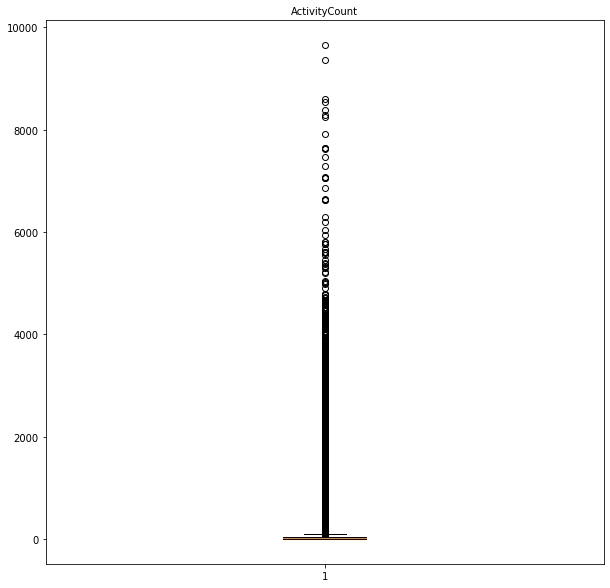

In [10]:
plt.figure(figsize=(10,10))
plt.boxplot(df_activity_data.ActivityCount)
plt.title("ActivityCount",fontsize=10)
plt.show()

In [18]:
df_activity_data.ActivityCount.describe()

count    4.559973e+06
mean     4.574190e+01
std      1.018964e+02
min      1.000000e+00
25%      6.000000e+00
50%      1.800000e+01
75%      4.600000e+01
max      9.654000e+03
Name: ActivityCount, dtype: float64

# Questions

### 1) How many rows are in the two datasets? If the log of emails represents 3% of the emails we sent over this period, how many emails did we send? (use python to print the numbers and display them nicely with commas)

In [38]:
print(f"{len(df_activity_data)}, {len(df_email_data)}, {round((100/3)*len(df_email_data))}")

4559973, 474163, 15805433


### 2) What are the earliest and most recent dates of emails sent in this dataset in California time (Pacific Standard Time Zone)? (use python to print the date in format mm/dd/yyy hour:minute in 24 hour time)

In [125]:
df_date = df_email_data['EmailSentDateTimeUtc']
df_date = pd.to_datetime(df_date).dt.strftime('%m/%d/%Y %H:%M:%S')
df_date.head()

0    07/31/2019 15:13:25
1    08/02/2019 02:15:52
2    08/07/2019 16:21:37
3    08/07/2019 16:38:03
4    08/12/2019 11:45:43
Name: EmailSentDateTimeUtc, dtype: object

In [126]:
sorted_dates = sorted(df_date)
ten_earliest = sorted_dates[:10]
ten_latest = sorted_dates[-10:]

In [131]:
#set the variable for Pacific timezone
pst = pytz.timezone('US/Pacific')

def convert_UTC_to_PST(datetimes):
    datetime_list = []
    for date in datetimes:
        date_time = datetime.strptime(date, "%m/%d/%Y %H:%M:%S")
        date_time = pytz.timezone('UTC').localize(date_time)
        date_time = date_time.astimezone(pst)
        datetime_list.append(date_time.strftime("%m-%d-%y %H:%M:%S"))
    return datetime_list

In [136]:
print("The ten earliest emails sent are:")
convert_UTC_to_PST(ten_earliest)

The ten earliest emails sent are:


['12-31-18 16:42:16',
 '12-31-18 16:42:18',
 '12-31-18 16:42:18',
 '12-31-18 16:42:19',
 '12-31-18 17:16:13',
 '12-31-18 17:16:26',
 '12-31-18 17:16:26',
 '12-31-18 17:16:27',
 '12-31-18 17:27:31',
 '12-31-18 17:27:32']

In [137]:
print("The ten latest emails sent are:")
convert_UTC_to_PST(ten_latest)

The ten latest emails sent are:


['12-31-20 15:12:34',
 '12-31-20 15:14:21',
 '12-31-20 15:20:28',
 '12-31-20 15:27:02',
 '12-31-20 15:28:36',
 '12-31-20 15:28:37',
 '12-31-20 15:28:38',
 '12-31-20 15:40:06',
 '12-31-20 15:45:43',
 '12-31-20 15:50:10']

### 3) Which 10 zip codes receive the most emails and how many emails do they receive?

In [50]:
df_email_data_groupby = df_email_data.groupby(df_email_data.ZipCode.tolist(),as_index=False).size()

In [51]:
print("The top ten zipcodes with the most recieved emails are as follows: \n")
print(df_email_data_groupby.sort_values(by='size', ascending=False)[:10].rename(columns={"index": "ZipCode", "size": "EmailCount"}))

The top ten zipcodes with the most recieved emails are as follows: 

       ZipCode  EmailCount
8975   63301.0         312
4353   33801.0         310
4416   34210.0         299
5088   38301.0         295
9576   67460.0         285
13690  95971.0         277
5524   42301.0         266
4707   36104.0         254
5431   40769.0         234
12440  85225.0         229


### 4) Plot two lines on a single graph. 
 - Total distinct users who were sent at least 1 email by month and year.
 - The monthly percentage of users who were sent an email and were active the same day

In [31]:
df_email = df_email_data.copy()
df_email['EmailSentDateTimeUtc'].head()

0    2019-07-31 15:13:25.817
1    2019-08-02 02:15:52.447
2    2019-08-07 16:21:37.293
3    2019-08-07 16:38:03.323
4    2019-08-12 11:45:43.293
Name: EmailSentDateTimeUtc, dtype: object

In [32]:
df_email['EmailSentDateTimeUtc'] = pd.to_datetime(df_email["EmailSentDateTimeUtc"]).dt.strftime('%Y/%m/%d %H:%M:%S')
df_email['EmailSentDateTimeUtc'].head()

0    2019/07/31 15:13:25
1    2019/08/02 02:15:52
2    2019/08/07 16:21:37
3    2019/08/07 16:38:03
4    2019/08/12 11:45:43
Name: EmailSentDateTimeUtc, dtype: object

In [33]:
#set the variable for Pacific timezone
pst = pytz.timezone('US/Pacific')

def convert_UTC_to_PST(date):
    date_time = datetime.strptime(date, "%Y/%m/%d %H:%M:%S")
    date_time = pytz.timezone('UTC').localize(date_time)
    date_time = date_time.astimezone(pst)
    return date_time.strftime("%Y-%m-%d %H:%M:%S")

In [34]:
df_email['EmailSentDateTimePST'] = df_email.apply(lambda row: convert_UTC_to_PST(row.EmailSentDateTimeUtc) , axis=1)

In [81]:
# df_email.head()

In [12]:
df_email["EmailSentDateTimePST"].isna().sum()

0

In [13]:
df_email["UserId"].isna().sum()

0

In [36]:
df_email["EmailSentDateTimePST"]= pd.to_datetime(df_email["EmailSentDateTimePST"])

In [37]:
df_email_id_date = df_email[["UserId", "EmailSentDateTimePST"]]

In [43]:
df_email_id_date['EmailSentDateTimePST'] = df_email_id_date['EmailSentDateTimePST'].dt.strftime('%Y-%m-%d')

In [44]:
df_email_id_date.head()

,UserId,EmailSentDateTimePST
0,851332105693,2019-07-31
1,369293054977,2019-08-01
2,938684493058,2019-08-07
3,50233193142,2019-08-07
4,369293054977,2019-08-12


In [45]:
total_email_dict = {}

for index, row in df_email_id_date.iterrows():
    id = row["EmailSentDateTimePST"]
    data = row["UserId"]
    
    if id in total_email_dict:
        total_email_dict[id].append(data)
    else:    
        total_email_dict[id] = [data]

In [56]:
# total_email_dict

In [48]:
total_count_email_dict = {}

for key, value in total_email_dict.items():
    total_count_email_dict[key] = len(set(value))

In [55]:
# total_count_email_dict

In [50]:
df_total_count_dict = pd.DataFrame(list(total_count_email_dict.items()), columns = ["Date", "EmailsSent"]) 

In [51]:
df_total_count_dict.head()

,Date,EmailsSent
0,2019-07-31,507
1,2019-08-01,873
2,2019-08-07,443
3,2019-08-12,857
4,2019-08-21,468


In [52]:
df_total_count_dict['Date'] = pd.to_datetime(df_total_count_dict['Date'])

total_groupy = df_total_count_dict.groupby([(df_total_count_dict['Date'].dt.year),(df_total_count_dict['Date'].dt.month)])

# print(total_groupy.first())


In [53]:
EmailsSent = total_groupy['EmailsSent'].first()

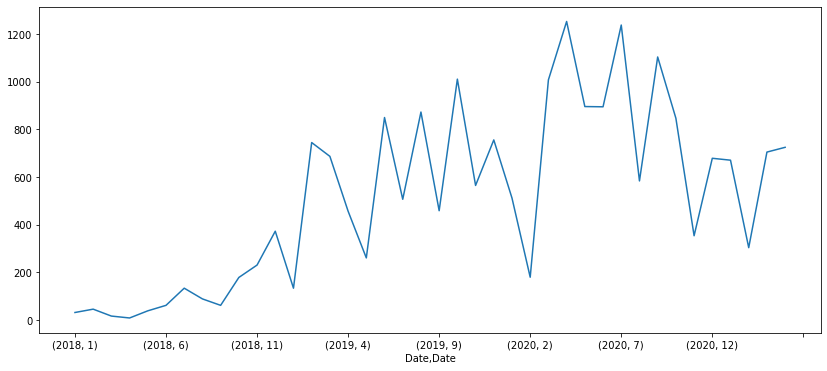

In [54]:
plt.figure(figsize=(14,6)) 
EmailsSent.plot(kind='line')
plt.show()

In [21]:
# The monthly percentage of users who were sent an email and were active the same day

In [57]:
df_activity = df_activity_data.copy()

In [58]:
df_activity.head()

,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


In [59]:
df_email["EmailSentDateTimePST"] = df_email["EmailSentDateTimePST"].dt.strftime('%Y-%m-%d')

In [60]:
# df_email.head()

In [61]:
df_user_id = df_email[["UserId", "EmailSentDateTimePST"]]
# df_user_id.head()

In [62]:
df_user_id = df_user_id.sort_values(by='UserId', ascending=False, na_position='first')
# df_user_id.head()

In [41]:
email_dict = {}

for index, row in df_user_id.iterrows():
    id = row["EmailSentDateTimePST"]
    data = row["UserId"]
    
    if id in email_dict:
        email_dict[id].append(data)
    else:    
        email_dict[id] = [data]

In [63]:
# email_dict

In [43]:
df_activity_id = df_activity[["UserId", "DateOfActivityPST"]]
# df_activity_id.head()

In [44]:
df_activity_id = df_activity_id.sort_values(by='UserId', ascending=False, na_position='first')
# df_activity_id.head()

In [46]:
activity_dict = {}

for index, row in df_activity_id.iterrows():
    id = row["DateOfActivityPST"]
    data = row["UserId"]
    
    if id in activity_dict:
        activity_dict[id].append(data)
    else:    
        activity_dict[id] = [data]

In [120]:
# activity_dict

In [50]:
compare_dates_dict = {}

for key, value in email_dict.items():
    if activity_dict.get(key, None):
        compare_dates_dict[key] = list(set(email_dict[key]) & set(activity_dict[key]))
    else:
        compare_dates_dict[key] = []

In [119]:
# compare_dates_dict

In [71]:
count_dates_dict = {}

for key, value in compare_dates_dict.items():
    count_dates_dict[key] = len(value)

In [117]:
# count_dates_dict

In [55]:
count_email_dict = {}

for key, value in email_dict.items():
    count_email_dict[key] = len(value)

In [118]:
# count_email_dict

In [62]:
df_count_dates_dict = pd.DataFrame(list(count_dates_dict.items()), columns = ["Date", "EmailsSentandActive"]) 

In [124]:
df_count_dates_dict['Date'] = pd.to_datetime(df_count_dates_dict['Date'])

In [64]:
# df_count_dates_dict.head()

In [65]:
# df_total_count_dict.head()

In [127]:
df_merge_dates = df_total_count_dict.merge(df_count_dates_dict, on='Date', how='outer')

In [129]:
df_merge_dates["ProportionSentToActive"] = df_merge_dates["EmailsSentandActive"]/df_merge_dates["EmailsSent"]

In [66]:
# df_merge_dates.head()

In [132]:
proportion_groupy = df_merge_dates.groupby([(df_merge_dates['Date'].dt.year),(df_merge_dates['Date'].dt.month)])

# print(proportion_groupy.first())

EmailsSentandActive = proportion_groupy['EmailsSentandActive'].first()

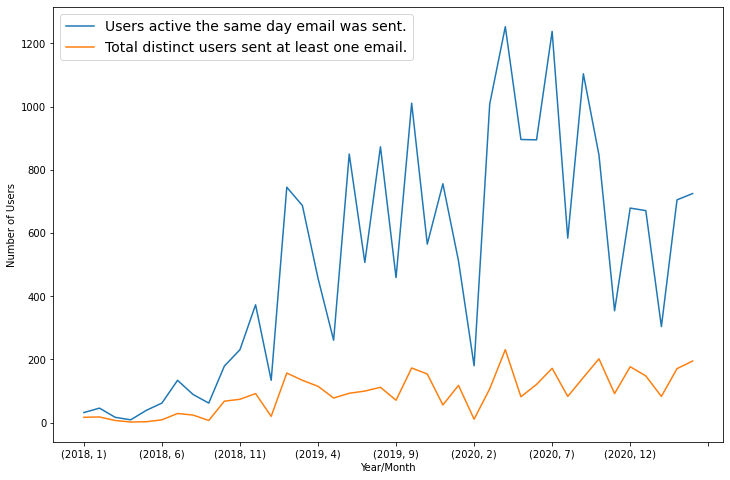

In [139]:
plt.figure(figsize=(12,8)) 
EmailsSent.plot(kind='line', label='Users active the same day email was sent.')
EmailsSentandActive.plot(kind='line', label='Total distinct users sent at least one email.')
plt.legend(loc='upper left', prop={'size': 14})
plt.ylabel("Number of Users")
plt.xlabel("Year/Month")
plt.show()

# 5) 
All the emails we send contain at least one link users can click which should send them to the FieldLevel app (where they would login and become active for that day). The team is curious if any of the links are broken. 

A broken link would be indicated by a record of email sent and clicked but no record of user activity on the day of the click.

Estimate how many emails (by EmailCampaignId) may have broken links. 

If you find an EmailCampaignId that has possible broken links, estimate an upper bound for the number of users it has effected 
 
Find the probability a user who gets email from us has experienced a broken link multiple times. 

For your answer, write a paragraph using clear language that non-technical members of the team will understand.

In [69]:
df_left_merge = df_email.merge(df_activity, on='UserId', how='left')

In [70]:
# df_left_merge.head()

In [71]:
df_null_activity = df_left_merge[df_left_merge['ActivityCount'].isna()]

In [72]:
# df_null_activity.head()

In [73]:
df_possible_broken_link = df_null_activity[df_null_activity['EmailSentDateTimeUtc'].notnull() & df_null_activity['EmailClickedDateTimeUtc'].notnull()]


In [74]:
possible_broken_campaigns = df_possible_broken_link["EmailCampaignId"].unique()

In [75]:
possible_users_affected = []
for campaign in possible_broken_campaigns:
    num_affected = round(len(df_possible_broken_link[df_possible_broken_link['EmailCampaignId'] == campaign])*(100/3))
    possible_users_affected.append(num_affected)
    print(f"{campaign}: {num_affected}")
print(f"\nPossible number of emails affected by a broken campaign link: {sum(possible_users_affected)}")

946235214960: 67
839979203061: 33
319208351769: 233
440300561088: 33
82833411612: 1100
653571247008: 100
653559880232: 233
479810600058: 1000
122198019089: 67
146804146660: 67
861847429503: 67
514819053576: 33
480484577588: 233
1007497544767: 67
572901749132: 33
184779603016: 67
863206683214: 33
192312213095: 33
895407739301: 33
567459485975: 33

Possible number of emails affected by a broken campaign link: 3565


In [76]:
possible_affected_users = []

for campaign in possible_broken_campaigns:
    possible_affected_users.append(len(df_left_merge[df_left_merge['EmailCampaignId'] == campaign]))
print(f"{sum(possible_affected_users)} users were contacted by campaign instances that contain patterns of possible broken links")
      

32981313 users were contacted by campaign instances that contain patterns of possible broken links


### Given that the user has experienced a broken link, what is the probability that they have encountered a broken link more than once?

In [181]:
len(df_email["UserId"].unique())

107325

In [182]:
len(df_possible_broken_link)

107

In [162]:
len(df_possible_broken_link.loc[df_possible_broken_link['UserId'].duplicated(), :])

11

### It was found that 32981313 users were contacted by emails campaigns that have been found to exhibit patterns of suspected broken email links. Bayes theorem gives us the conditional probability that users have experienced multiple broken links, given that they have recieved at least one email with a broken link. In this way, we see that there is a 10.28% chance that a user will experience more than one broken link if they have recieved at least one email with a broken link. 

# 6) 
The team's product manager is thinking we may be sending too much email. 
Is there a campaign that we should consider no longer sending? 
(e.g. its performance has never been good). 
When looking at performance of the emails does time matter or do they perform consistently over time?

In [79]:
# df_email.head()

In [146]:
df_left_merge = df_email.merge(df_activity, on='UserId', how='left')

In [78]:
# df_left_merge.head(2)

In [149]:
df_campaign = df_left_merge[["EmailCampaignId", "EmailSentDateTimePST", "ActivityCount"]]

In [77]:
# df_campaign.head(2)

In [156]:
df_campaign_groupby = df_campaign.groupby(["EmailCampaignId"]).sum()

In [160]:
df_campaign_groupby = df_campaign_groupby.sort_values(by='ActivityCount', ascending=True, na_position='first')

In [166]:
round(len(df_campaign_groupby)*.20)

17

### These are the bottom 20% performing email campaigns to date:

In [172]:
df_campaign_groupby[:17]

,ActivityCount
EmailCampaignId,
477208483389,0.0
1016477009704,0.0
398544850539,14.0
82849832050,18.0
1057986473750,18.0
779137430622,22.0
491462437932,483.0
897577197667,1486.0
514673770369,1836.0


### Looking at the performance of specific campaigns over time

In [262]:
campaigns_list = df_campaign['EmailCampaignId'].unique()
# sorted(campaigns_list)

In [225]:
len(campaigns_list)

84

In [244]:
def plot_campaigns(start, end):    
    plt.figure(figsize=(15,15))
    i = 1
    for campaign in campaigns_list[start:end]:
        df_specific_campaign = df_campaign.loc[df_campaign['EmailCampaignId'] == campaign]
        df = df_specific_campaign.sort_values('EmailSentDateTimePST', ascending=True)

        plt.subplot(6,2,i)
        plt.title(campaign)
        x = df['EmailSentDateTimePST']
        y = df['ActivityCount']
        plt.xticks(rotation='20')
        plt.plot(x, y)

        i+=1
    plt.tight_layout()
    plt.show()

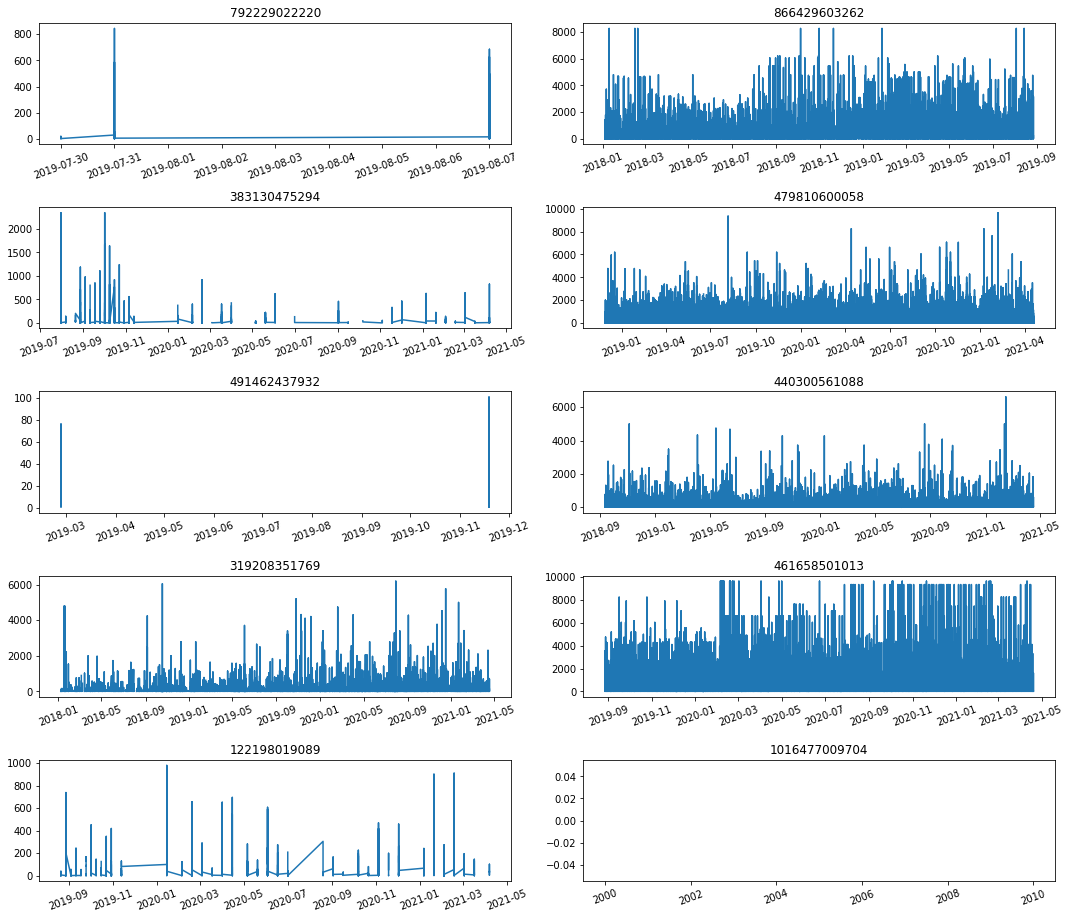

In [245]:
plot_campaigns(0, 10)

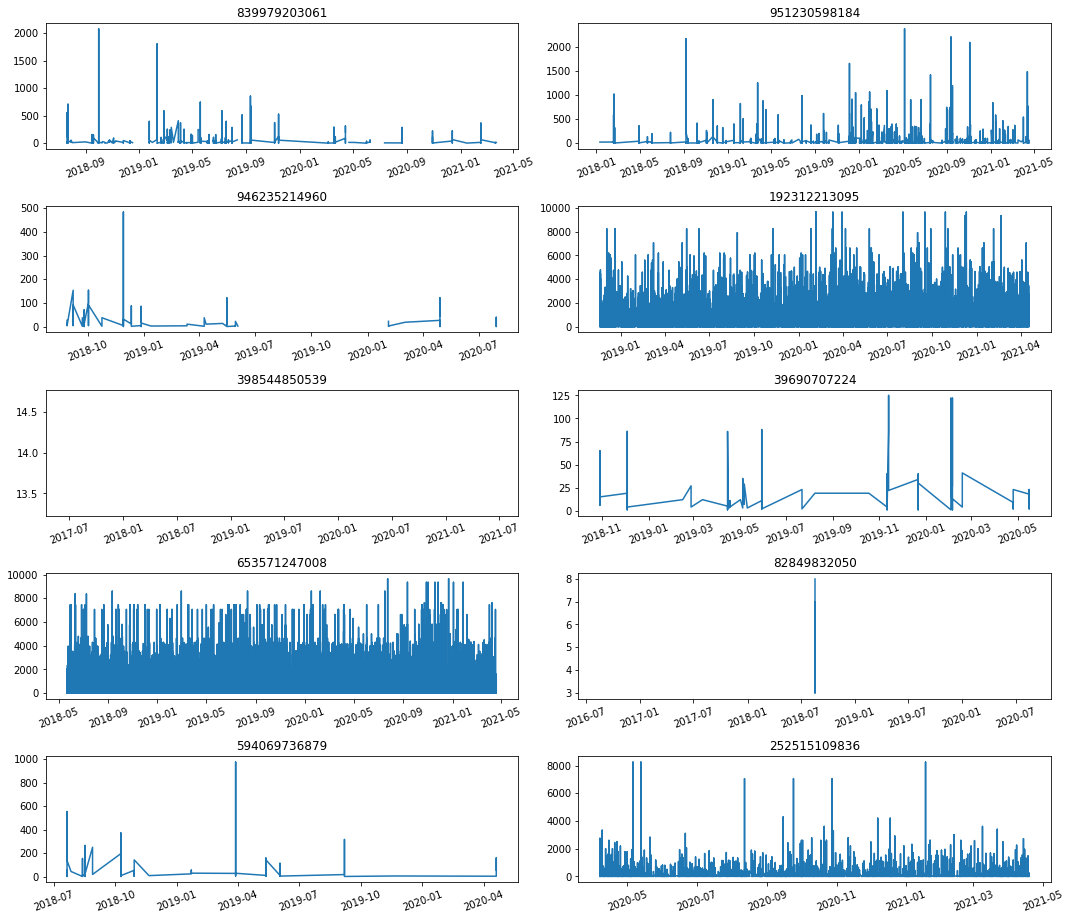

In [248]:
plot_campaigns(10, 20)

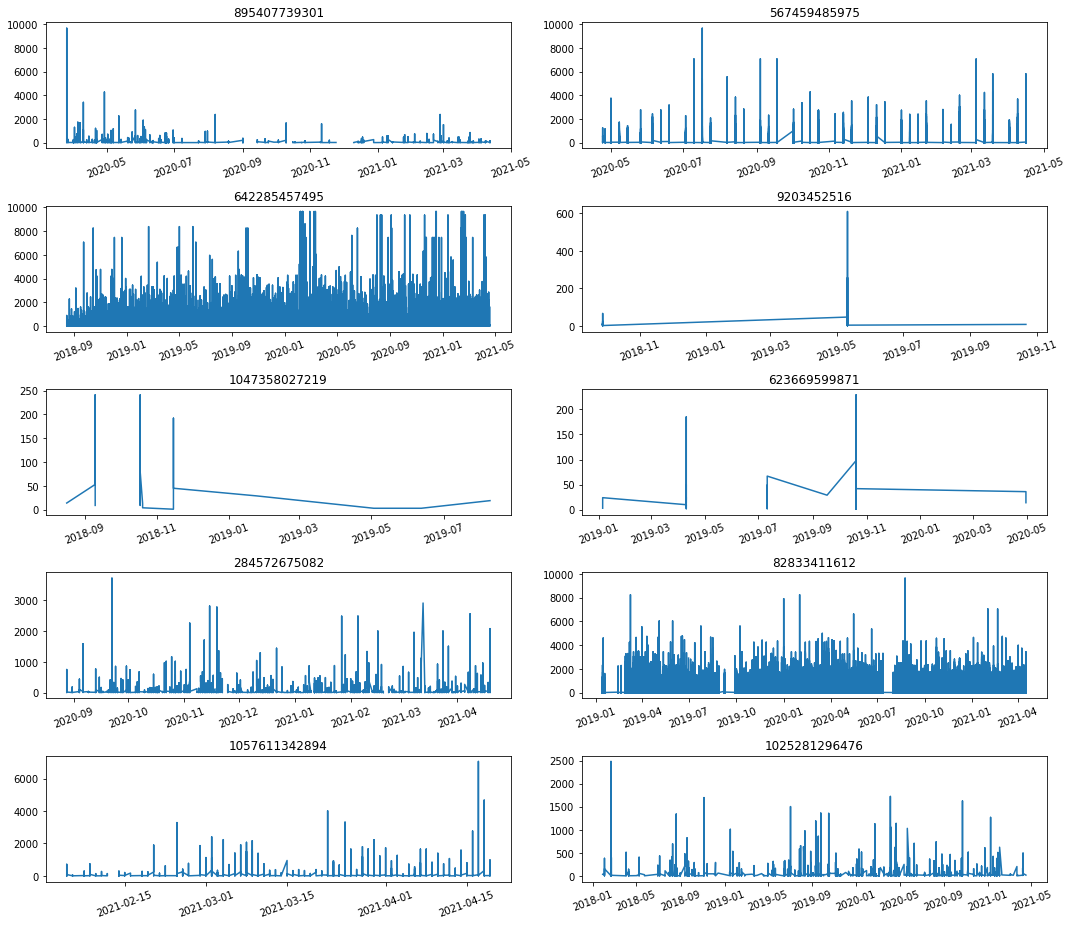

In [249]:
plot_campaigns(20, 30)

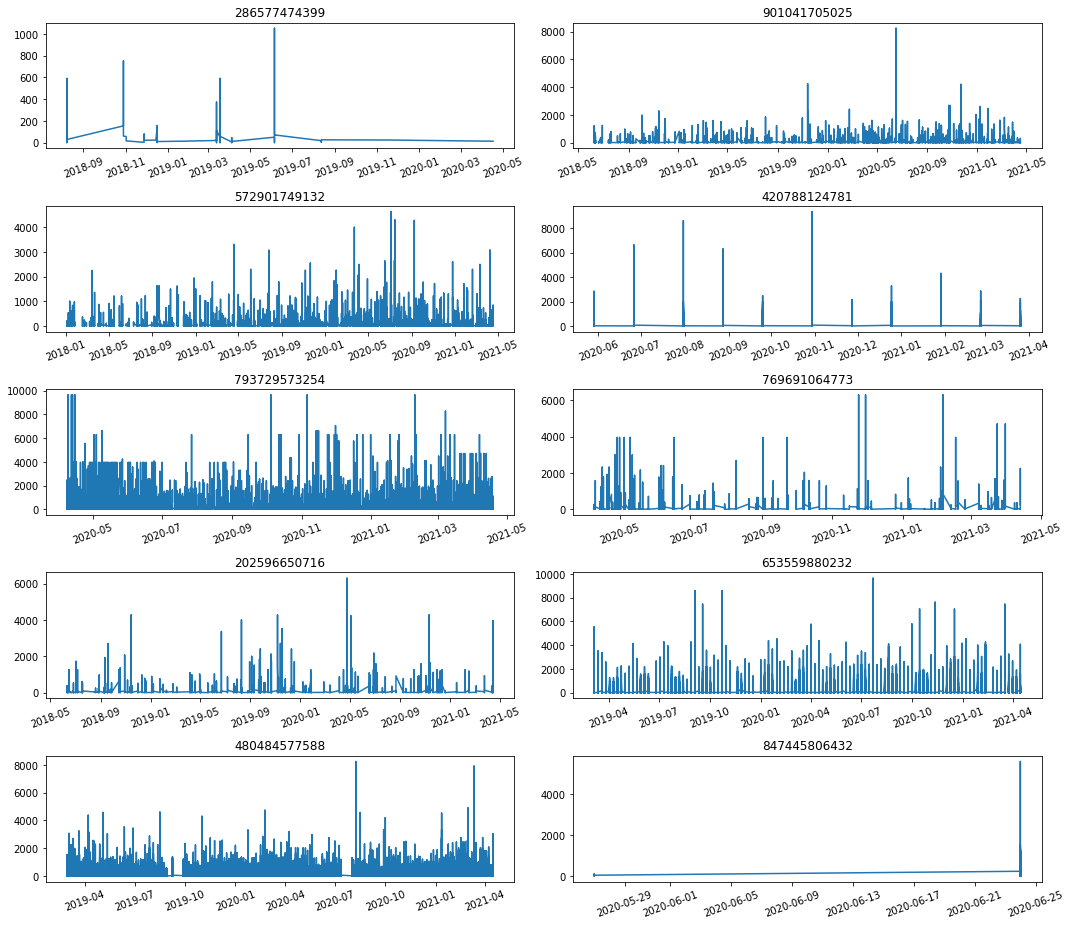

In [250]:
plot_campaigns(30, 40)

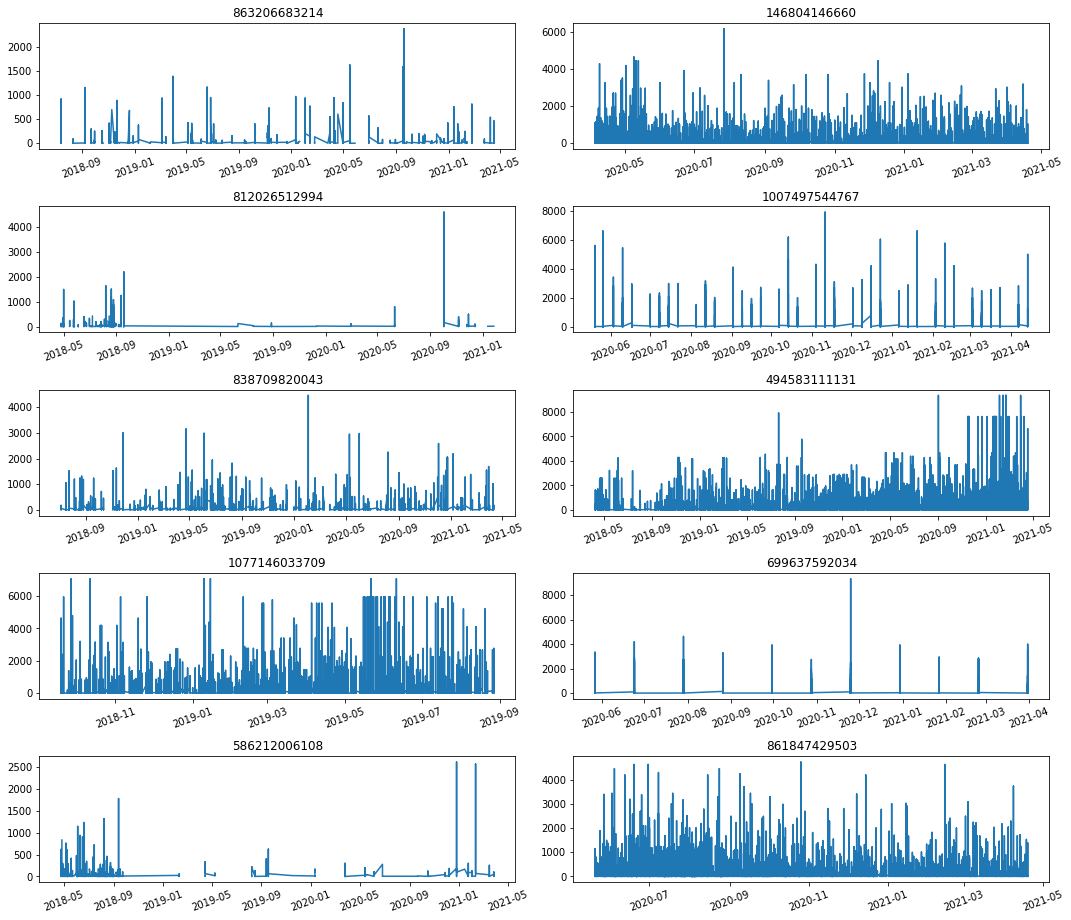

In [251]:
plot_campaigns(40, 50)

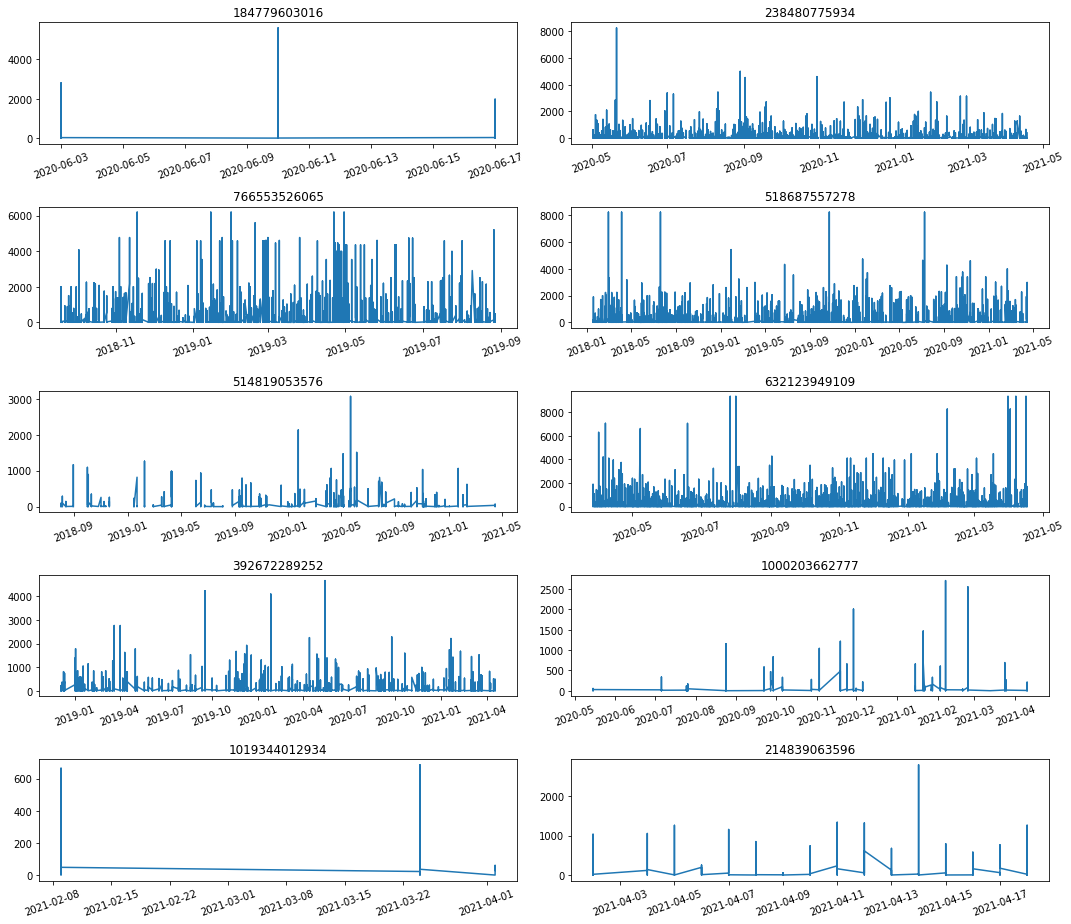

In [252]:
plot_campaigns(50, 60)

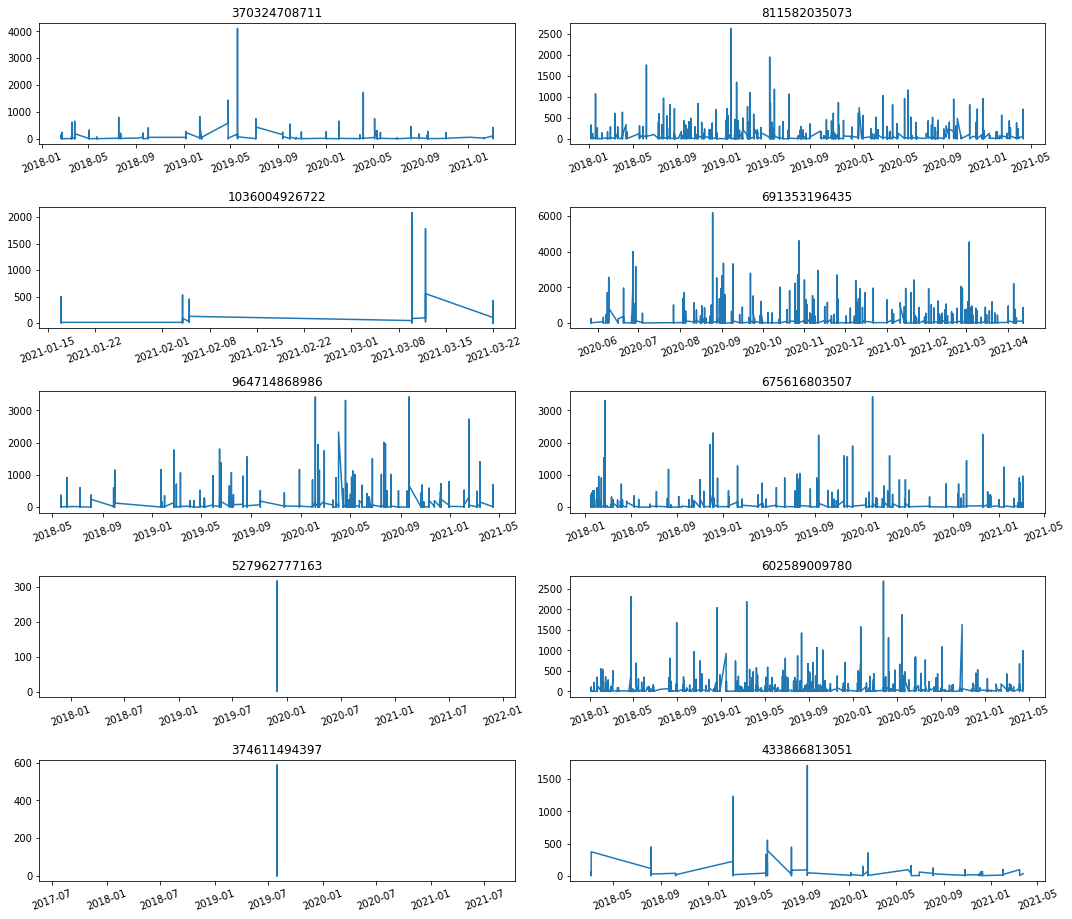

In [253]:
plot_campaigns(60, 70)

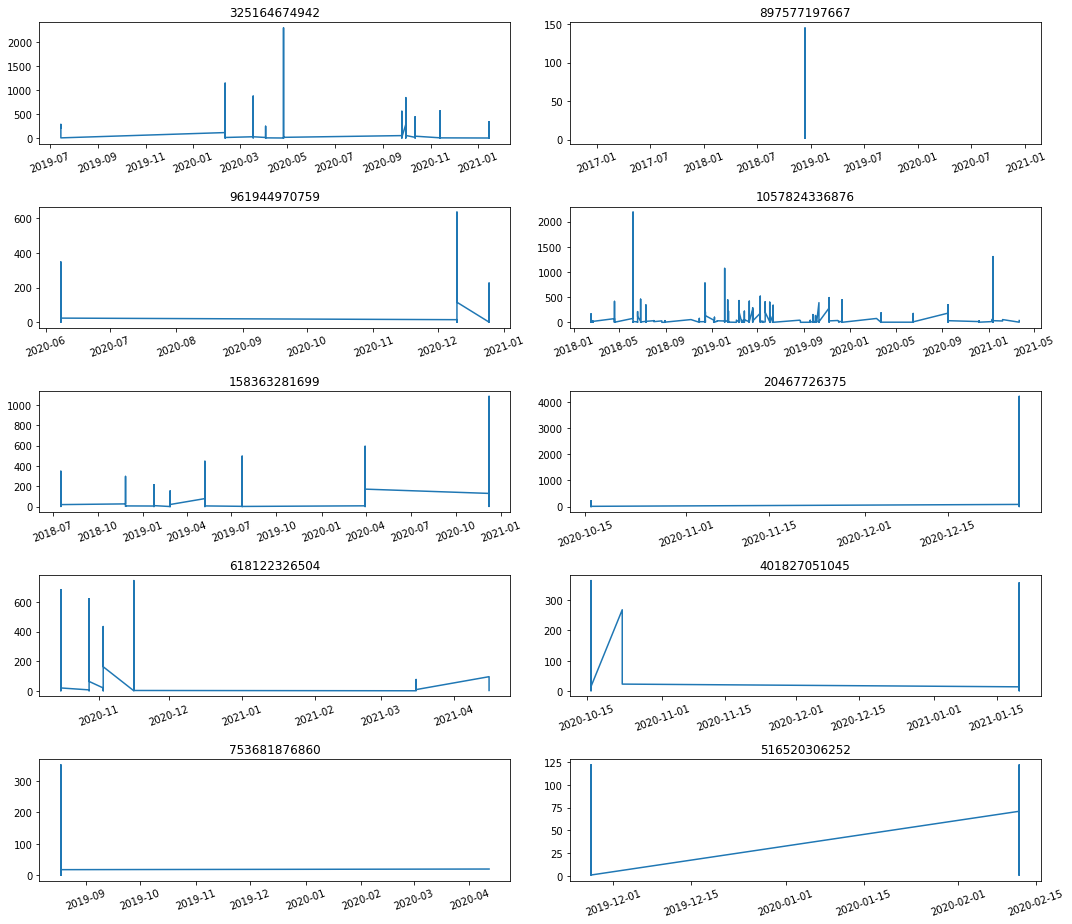

In [257]:
plot_campaigns(70, 80)

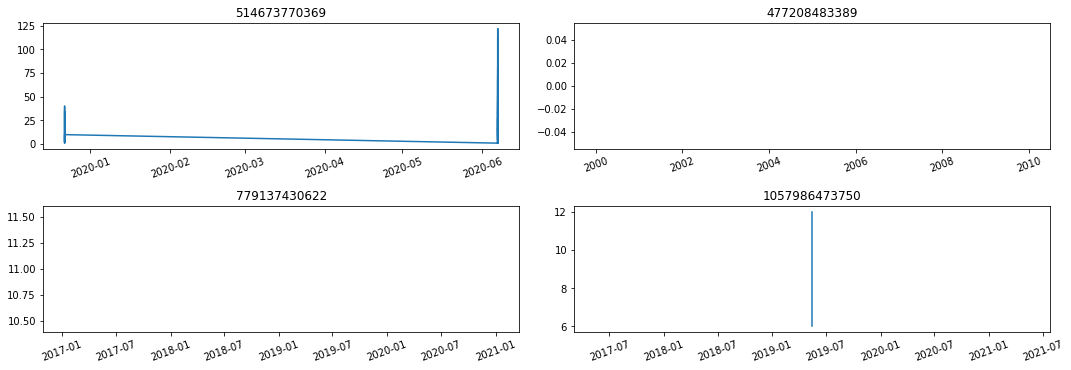

In [258]:
plot_campaigns(80, 84)

### Looking at the activiyty generated by each campaign over the lifetime of the campaign, we can see faint trends in a small collection of campaigns. Notably, positive activity growth over time during the 1057611342894, 461658501013, 494583111131. We can see that campaigns 895407739301 and 839979203061 reflect diminishing activity over their lifetime. Though most prominently we see that the activity with respect to email campaign does remains constant or with no discernable pattern at this level of granularity. 

# 7) 
Almost every email that we send has a 'call to action' button that sends users to the FieldLevel app. 
The team wants to experiment with the way the 'call to action' buttons are designed. 
They have a new design that they think will encourage more people to click on the button. 
In order to test the new design the team will select a group of users to experiment on. 

They plan to separate the users who get email into two 'experimental groups':
an 'experiment' group whose emails will have the new button design after the experiment launch data
a 'control' group whose email will have the current button design after the experiment launch data

The team wants to have about 50% of the users in the experiment assigned to the 'experiment' group and 50% assigned to the control group. 
They are using the following rules to assign users to the groups:

Users with a userid between 20000000 and 1000000000000 will be included in the experiment

Users with a userid greater than 498689408027 will be the 'experiment' group

Users with a userid less than or equal to 498689408027 will be the 'control' group

Once the experiment launches the team wants to track changes to the probability of an email getting clicked. 

In preparation for the experiment launch, plot a graph comparing the probability a user clicks on an email for each of the two experimental groups aggregated on a daily basis. 

In a paragraph, describe whether you think this is a good experimental design.

In [80]:
# df_activity.head()

In [272]:
df_20000000= df_activity[df_activity['UserId'] >= 20000000]
len(df_20000000)

4559957

In [283]:
df_1000000000000 = df_activity[df_activity['UserId'] <= 1000000000000]
len(df_1000000000000)

4162898

In [273]:
df_20000000_1000000000000 = df_activity[(df_activity['UserId'] > 20000000) & (df_activity['UserId'] < 1000000000000)]
len(df_20000000_1000000000000)


4162882

In [281]:
df_control_group = df_activity[df_activity['UserId'] <= 498689408027]
len(df_control_group)/len(df_20000000_1000000000000)

0.49959907583256025

In [282]:
df_experiment_group = df_activity[df_activity['UserId'] > 498689408027]
len(df_experiment_group)/len(df_20000000_1000000000000)

0.595789407434561

In [287]:
experiment_group_ids = df_experiment_group["UserId"].unique()

In [288]:
control_group_ids = df_control_group["UserId"].unique()

## Experiment Group
Build experiment group dataframe with user instances for total email sent, total activity amount, and total login count. 

In [419]:
df_experiment_group_emails = df_email[df_email['UserId'].isin(experiment_group_ids)]

In [546]:
# df_experiment_group_emails.head()

In [421]:
df_experiment_group_emails['EmailClickedDateTimeUtc'] = pd.to_datetime(df_experiment_group_emails['EmailClickedDateTimeUtc'])
df_experiment_group_emails['EmailSentDateTimeUtc'] = pd.to_datetime(df_experiment_group_emails['EmailSentDateTimeUtc'])
df_experiment_group_emails['EmailClickedDateTimeUtc'] = df_experiment_group_emails['EmailClickedDateTimeUtc'].dt.strftime('%Y-%m-%d')
df_experiment_group_emails['EmailSentDateTimeUtc'] = df_experiment_group_emails['EmailSentDateTimeUtc'].dt.strftime('%Y-%m-%d')



In [423]:
df_experiment_group_emails_dates = df_experiment_group_emails[["EmailSentDateTimeUtc", "EmailClickedDateTimeUtc"]]


In [487]:
# df_experiment_group_emails_dates

In [425]:
experiment_group_dict = {}

for index, row in df_experiment_group_emails_dates.iterrows():
    id = row["EmailSentDateTimeUtc"]    
    if id in experiment_group_dict:
        experiment_group_dict[id].append(id)
    else:    
        experiment_group_dict[id] = [id]

In [427]:
count_experiment_group_dict = {}

for key, value in experiment_group_dict.items():
    count_experiment_group_dict[key] = len(value)

In [547]:
# count_experiment_group_dict


In [562]:
df_total_count = pd.DataFrame(list(count_experiment_group_dict.items()), columns = ["Date", "TotalEmailSent"]) 
df_total_count = df_total_count.sort_values('Date')
df_total_count['Date'] = pd.to_datetime(df_total_count['Date'])
df_total_count['Date'] = df_total_count['Date'].dt.strftime('%Y-%m-%d')
# df_total_count.head()

In [460]:
experiment_group_clicked_dict = {}

for index, row in df_experiment_group_emails_dates.iterrows():
    id = row["EmailClickedDateTimeUtc"]    
    if id in experiment_group_clicked_dict:
        experiment_group_clicked_dict[id].append(id)
    else:    
        experiment_group_clicked_dict[id] = [id]

In [462]:
clicked_count_experiment_group_dict = {}

for key, value in experiment_group_clicked_dict.items():
    clicked_count_experiment_group_dict[key] = len(value)

In [548]:
# clicked_count_experiment_group_dict


In [465]:
df_exp_clicked_count = pd.DataFrame(list(clicked_count_experiment_group_dict.items()), columns = ["Date", "TotalEmailClicked"]) 
df_exp_clicked_count = df_exp_clicked_count[1:]
df_exp_clicked_count = df_exp_clicked_count.sort_values('Date')
# df_exp_clicked_count.head()


In [561]:
df_experiment_merged = df_total_count.merge(df_exp_clicked_count, how='outer', on='Date')
# df_experiment_merged.head()


In [468]:
df_experiment_merged["ProbabilityClicked"] = df_experiment_merged["TotalEmailClicked"]/df_experiment_merged["TotalEmailSent"]
# df_experiment_merged.head()


In [470]:
df_experiment_merged['ProbabilityClicked'] = df_experiment_merged['ProbabilityClicked'].fillna(0)
# df_experiment_merged.head()

In [477]:
df_experiment_merged_reduced = df_experiment_merged[["Date", "ProbabilityClicked"]] 
df_experiment_merged_reduced['Date'] = pd.to_datetime(df_experiment_merged_reduced['Date'])


In [485]:
experiment_probability_groupy = df_experiment_merged_reduced.groupby([(df_experiment_merged_reduced['Date'].dt.year),(df_experiment_merged_reduced['Date'].dt.month), (df_experiment_merged_reduced['Date'].dt.day)])
EXPProbabilityClicked = experiment_probability_groupy['ProbabilityClicked'].first()
# EXPProbabilityClicked


## Control Group
Build control group dataframe with user instances for total email sent, total activity amount, and total login count. 


In [560]:
control_group_ids = df_control_group["UserId"].unique()
df_control_group_emails = df_email[df_email['UserId'].isin(control_group_ids)]
# df_control_group_emails.head()

In [507]:
df_control_group_emails['EmailClickedDateTimeUtc'] = pd.to_datetime(df_control_group_emails['EmailClickedDateTimeUtc'])
df_control_group_emails['EmailSentDateTimeUtc'] = pd.to_datetime(df_control_group_emails['EmailSentDateTimeUtc'])
df_control_group_emails['EmailClickedDateTimeUtc'] = df_control_group_emails['EmailClickedDateTimeUtc'].dt.strftime('%Y-%m-%d')
df_control_group_emails['EmailSentDateTimeUtc'] = df_control_group_emails['EmailSentDateTimeUtc'].dt.strftime('%Y-%m-%d')


In [559]:
df_control_group_emails_dates = df_control_group_emails[["EmailSentDateTimeUtc", "EmailClickedDateTimeUtc"]]
# df_control_group_emails_dates.head()

In [509]:
control_group_dict = {}

for index, row in df_control_group_emails_dates.iterrows():
    id = row["EmailSentDateTimeUtc"]    
    if id in control_group_dict:
        control_group_dict[id].append(id)
    else:    
        control_group_dict[id] = [id]

In [558]:
# control_group_dict

In [511]:
count_control_group_dict = {}

for key, value in control_group_dict.items():
    count_control_group_dict[key] = len(value)

In [557]:
# count_control_group_dict

In [556]:
df_control_count = pd.DataFrame(list(count_control_group_dict.items()), columns = ["Date", "TotalEmailSent"]) 
df_control_count = df_control_count.sort_values('Date')
df_control_count['Date'] = pd.to_datetime(df_control_count['Date'])
df_control_count['Date'] = df_control_count['Date'].dt.strftime('%Y-%m-%d')
# df_control_count.head()

In [514]:
control_group_clicked_dict = {}

for index, row in df_control_group_emails_dates.iterrows():
    id = row["EmailClickedDateTimeUtc"]    
    if id in control_group_clicked_dict:
        control_group_clicked_dict[id].append(id)
    else:    
        control_group_clicked_dict[id] = [id]

In [549]:
# control_group_clicked_dict

In [516]:
clicked_count_control_group_dict = {}

for key, value in control_group_clicked_dict.items():
    clicked_count_control_group_dict[key] = len(value)

In [550]:
# clicked_count_control_group_dict

In [551]:
df_contr_clicked_count = pd.DataFrame(list(clicked_count_control_group_dict.items()), columns = ["Date", "TotalEmailClicked"]) 
df_contr_clicked_count = df_contr_clicked_count[1:]
df_contr_clicked_count = df_contr_clicked_count.sort_values('Date')

# df_contr_clicked_count.head()

In [552]:
df_control_merged = df_control_count.merge(df_contr_clicked_count, how='outer', on='Date')
# df_control_merged.head()

In [553]:
df_control_merged["ProbabilityClicked"] = df_control_merged["TotalEmailClicked"]/df_control_merged["TotalEmailSent"]
# df_control_merged.head()

In [554]:
df_control_merged['ProbabilityClicked'] = df_control_merged['ProbabilityClicked'].fillna(0)
# df_control_merged.head()

In [523]:
df_control_merged_reduced = df_control_merged[["Date", "ProbabilityClicked"]] 
df_control_merged_reduced['Date'] = pd.to_datetime(df_control_merged_reduced['Date'])

In [555]:
control_probability_groupy = df_control_merged_reduced.groupby([(df_control_merged_reduced['Date'].dt.year),(df_control_merged_reduced['Date'].dt.month), (df_control_merged_reduced['Date'].dt.day)])
CONTRProbabilityClicked = control_probability_groupy['ProbabilityClicked'].first()
# CONTRProbabilityClicked

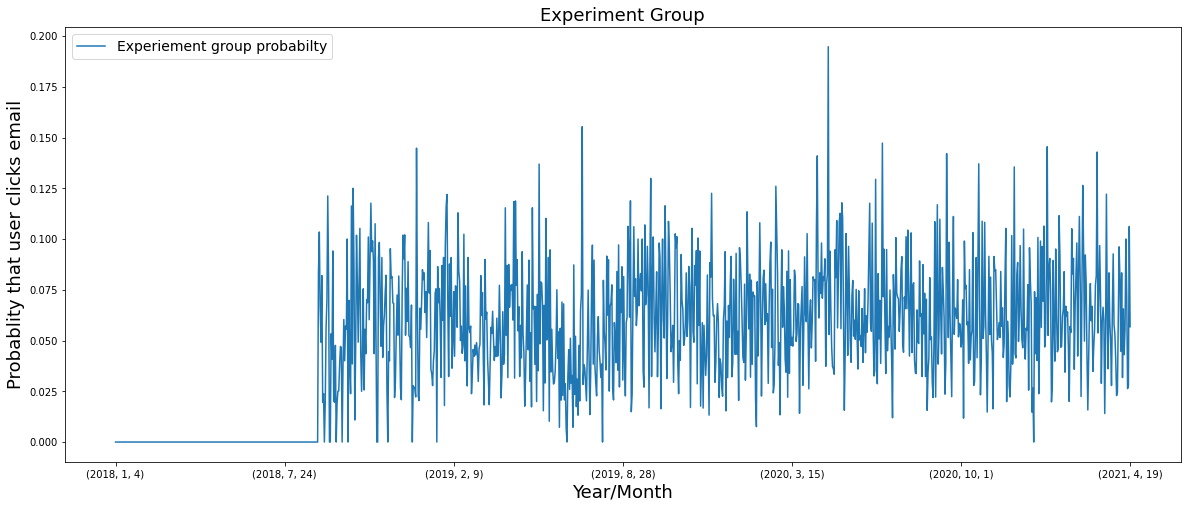

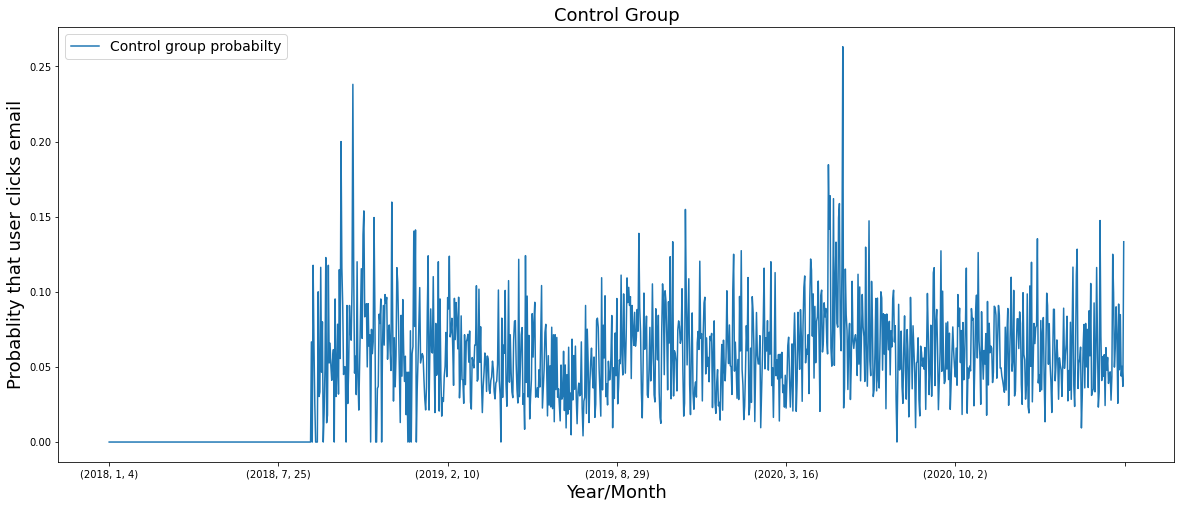

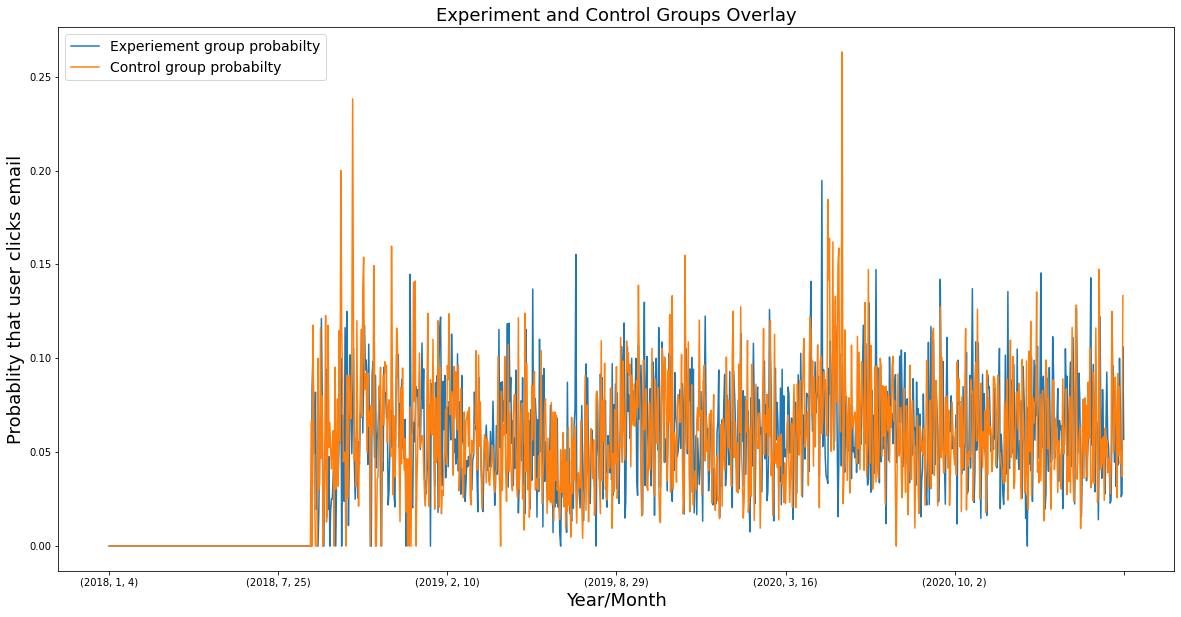

In [544]:
plt.figure(figsize=(20,8)) 
ProbabilityClicked.plot(kind='line', label='Experiement group probabilty')
plt.legend(loc='upper left', prop={'size': 14})
plt.ylabel("Probablity that user clicks email", fontsize=18)
plt.xlabel("Year/Month", fontsize=18)
plt.title("Experiment Group", fontsize=18)

plt.figure(figsize=(20,8))
CONTRProbabilityClicked.plot(kind='line', label='Control group probabilty')
plt.legend(loc='upper left', prop={'size': 14})
plt.ylabel("Probablity that user clicks email", fontsize=18)
plt.xlabel("Year/Month",fontsize=18)
plt.title("Control Group", fontsize=18)
# plt.show()

plt.figure(figsize=(20,10)) 
ProbabilityClicked.plot(kind='line', label='Experiement group probabilty')
CONTRProbabilityClicked.plot(kind='line', label='Control group probabilty')
plt.legend(loc='upper left', prop={'size': 14})
plt.ylabel("Probablity that user clicks email", fontsize=18)
plt.xlabel("Year/Month", fontsize=18)
plt.title("Experiment and Control Groups Overlay", fontsize=18)
plt.show()

### Ploting the probabilities of each group, we see that each group runs a similar historical pattern. To make this experiment more robust, I would like to sample the group populations randomly, instead of sorted and picked by sequential user ID. I would also be interested in conducting more research into the group as a whole to investigate weather there are statistically different sub-groups that would benefit from not being combined during the experiement.  

# 8)
Finally, the product manager is worried emails are not having the impact we think.

In particular they are concerned that unengaged users (users who have not logged into FieldLevel for 6 months) do not open or click on emails and because of this, efforts to re-engage users that focus on email will not be effective. 

The PM would like you to explore whether there is evidence that emails are effective with engaged users (users who log in without emails prompting them) but not effective on unengaged users. 

Explore the data, visualizing the relationship between emails sent and user activity both in login and activity count.

Write a paragraph to support or argue against the product managers concern. 

Use statistical methods support your conclusion but balance that with plain language that non-technical users can understand.


In [ ]:
# 2020-10-19 6 months from most recent activity data point

In [599]:
df_active_users = df_activity[df_activity['DateOfActivityPST'] >= "2020-10-19"]

In [600]:
df_active_users.head()

,UserId,DateOfActivityPST,ActivityCount
171,435228414681,2020-10-19,3
172,435228414681,2020-10-22,13
173,435228414681,2020-10-27,77
174,435228414681,2020-10-30,14
175,435228414681,2020-11-04,3


In [601]:
df_inactive_users = df_activity[df_activity['DateOfActivityPST'] < "2020-10-19"]

In [602]:
df_inactive_users.head()

,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


In [603]:
active_users_ids = df_active_users["UserId"].unique()
len(active_users_ids)

51787

In [604]:
inactive_users_ids = df_inactive_users["UserId"].unique()
len(inactive_users_ids)

84833

In [605]:
matched_users = list(set(active_users_ids) & set(active_users_ids))

In [606]:
inactive_users_ids_cleaned = []

for element in inactive_users_ids:
    if element not in matched_users:
        inactive_users_ids_cleaned.append(element)

In [607]:
len(inactive_users_ids_cleaned)

38264

# Active Users

In [619]:
df_active_use_activity = df_activity[df_activity["UserId"].isin(active_users_ids)]
df_active_use_email = df_email[df_email["UserId"].isin(active_users_ids)]

In [697]:
# df_active_use_activity.head()

In [698]:
# df_active_use_email.head()

In [637]:
active_use_email_dict = {}

for index, row in df_active_use_email.iterrows():
    id = row["UserId"]
    data = row["LogId"]
    
    if id in active_use_email_dict:
        active_use_email_dict[id].append(data)
    else:    
        active_use_email_dict[id] = [data]

In [638]:
count_active_use_email_dict = {}

for key, value in active_use_email_dict.items():
    count_active_use_email_dict[key] = len(value)

In [644]:
# count_active_use_email_dict

In [642]:
df_total_count = pd.DataFrame(list(count_active_use_email_dict.items()), columns = ["UserId", "EmailsSent"]) 


In [692]:
# df_total_count.head()

In [657]:
active_use_activity_dict = {}

for index, row in df_active_use_activity.iterrows():
    id = row["UserId"]
    data = row["ActivityCount"]
    
    if id in active_use_activity_dict:
        active_use_activity_dict[id].append(data)
    else:    
        active_use_activity_dict[id] = [data]

In [676]:
# active_use_activity_dict

In [662]:
sum_active_use_ActivityCount_dict = {}

for key, value in active_use_activity_dict.items():
    sum_active_use_ActivityCount_dict[key] = sum(value)

In [677]:
# sum_active_use_ActivityCount_dict

In [666]:
df_sum_active_use_ActivityCount = pd.DataFrame(list(sum_active_use_ActivityCount_dict.items()), columns = ["UserId", "TotalUserActivity"]) 


In [691]:
# df_sum_active_use_ActivityCount.head()

In [668]:
active_use_login_dict = {}

for index, row in df_active_use_activity.iterrows():
    id = row["UserId"]
    data = row["DateOfActivityPST"]
    
    if id in active_use_login_dict:
        active_use_login_dict[id].append(data)
    else:    
        active_use_login_dict[id] = [data]

In [680]:
# active_use_login_dict

In [671]:
count_active_use_LoginDate_dict = {}

for key, value in active_use_login_dict.items():
    count_active_use_LoginDate_dict[key] = len(value)

In [681]:
# count_active_use_LoginDate_dict

In [673]:
df_count_active_use_LoginCount = pd.DataFrame(list(count_active_use_LoginDate_dict.items()), columns = ["UserId", "TotalUserLogin"]) 


In [690]:
# df_count_active_use_LoginCount.head()

In [687]:
df_active_user_values = pd.merge(df_total_count, df_sum_active_use_ActivityCount, on='UserId')

In [688]:
df_active_user_values = pd.merge(df_active_user_values, df_count_active_use_LoginCount, on='UserId')

In [689]:
df_active_user_values.head()

,UserId,EmailsSent,TotalUserActivity,TotalUserLogin
0,851332105693,1,33,3
1,186430397022,3,1383,29
2,57254519310,8,3969,47
3,1027868774133,1,75,3
4,1027045884215,1,198,4


# Inactive Users

In [693]:
df_inactive_use_activity = df_activity[df_activity["UserId"].isin(inactive_users_ids_cleaned)]
df_inactive_use_email = df_email[df_email["UserId"].isin(inactive_users_ids_cleaned)]

In [694]:
inactive_use_email_dict = {}

for index, row in df_inactive_use_email.iterrows():
    id = row["UserId"]
    data = row["LogId"]
    
    if id in inactive_use_email_dict:
        inactive_use_email_dict[id].append(data)
    else:    
        inactive_use_email_dict[id] = [data]

In [695]:
count_inactive_use_email_dict = {}

for key, value in inactive_use_email_dict.items():
    count_inactive_use_email_dict[key] = len(value)

In [722]:
# count_inactive_use_email_dict

In [699]:
df_inactive_total_count = pd.DataFrame(list(count_inactive_use_email_dict.items()), columns = ["UserId", "EmailsSent"]) 


In [729]:
# df_inactive_total_count.head()

In [704]:
inactive_use_activity_dict = {}

for index, row in df_inactive_use_activity.iterrows():
    id = row["UserId"]
    data = row["ActivityCount"]
    
    if id in inactive_use_activity_dict:
        inactive_use_activity_dict[id].append(data)
    else:    
        inactive_use_activity_dict[id] = [data]

In [721]:
# inactive_use_activity_dict

In [706]:
sum_inactive_use_ActivityCount_dict = {}

for key, value in inactive_use_activity_dict.items():
    sum_inactive_use_ActivityCount_dict[key] = sum(value)

In [720]:
# sum_inactive_use_ActivityCount_dict

In [708]:
df_sum_inactive_use_ActivityCount = pd.DataFrame(list(sum_inactive_use_ActivityCount_dict.items()), columns = ["UserId", "TotalUserActivity"]) 


In [727]:
# df_sum_inactive_use_ActivityCount.head()

In [710]:
inactive_use_login_dict = {}

for index, row in df_inactive_use_activity.iterrows():
    id = row["UserId"]
    data = row["DateOfActivityPST"]
    
    if id in inactive_use_login_dict:
        inactive_use_login_dict[id].append(data)
    else:    
        inactive_use_login_dict[id] = [data]

In [719]:
# inactive_use_login_dict

In [714]:
count_inactive_use_LoginDate_dict = {}

for key, value in inactive_use_login_dict.items():
    count_inactive_use_LoginDate_dict[key] = len(value)

In [718]:
# count_inactive_use_LoginDate_dict

In [716]:
df_count_inactive_use_LoginCount = pd.DataFrame(list(count_inactive_use_LoginDate_dict.items()), columns = ["UserId", "TotalUserLogin"]) 


In [728]:
# df_count_inactive_use_LoginCount.head()

In [753]:
df_inactive_user_values = pd.merge(df_inactive_total_count, df_sum_inactive_use_ActivityCount, on='UserId')

In [754]:
df_inactive_user_values = pd.merge(df_inactive_user_values, df_count_inactive_use_LoginCount, on='UserId')

In [755]:
df_inactive_user_values.head()

,UserId,EmailsSent,TotalUserActivity,TotalUserLogin
0,369293054977,6,1713,29
1,620779573047,1,12,1
2,519974090458,2,14,1
3,59945322238,6,55,5
4,369357326445,1,8,1


In [756]:
df_email_vs_total_activity = df_inactive_user_values[["EmailsSent", "TotalUserActivity"]]
df_email_vs_total_activity = df_email_vs_total_activity.sort_values("EmailsSent")
# df_email_vs_total_activity

In [760]:
df_email_vs_total_login = df_inactive_user_values[["EmailsSent", "TotalUserLogin"]]
df_email_vs_total_login = df_email_vs_total_login.sort_values("EmailsSent")
# df_email_vs_total_login

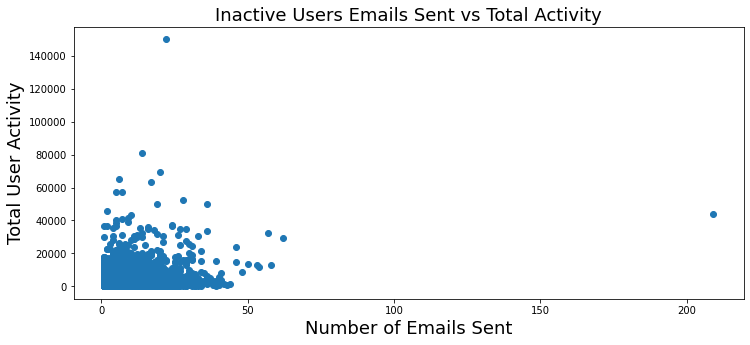

In [749]:
plt.figure(figsize=(12,5)) 
y = df_email_vs_total_activity["TotalUserActivity"]
x = df_email_vs_total_activity["EmailsSent"]

plt.scatter(x, y)
plt.ylabel("Total User Activity", fontsize=18)
plt.xlabel("Number of Emails Sent", fontsize=18)
plt.title("Inactive Users Emails Sent vs Total Activity", fontsize=18)
plt.show()

In [774]:
y = df_email_vs_total_activity["TotalUserActivity"]
x = df_email_vs_total_activity["EmailsSent"]
print(stats.linregress(x, y))

LinregressResult(slope=219.7270568602861, intercept=-132.37481057728928, rvalue=0.34069049450135497, pvalue=0.0, stderr=3.099906694332238, intercept_stderr=16.367046285930176)


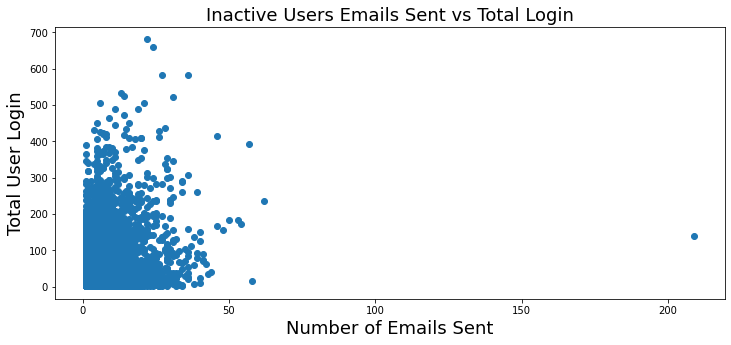

In [759]:
plt.figure(figsize=(12,5)) 
y = df_email_vs_total_login["TotalUserLogin"]
x = df_email_vs_total_login["EmailsSent"]

plt.scatter(x, y)
plt.ylabel("Total User Login", fontsize=18)
plt.xlabel("Number of Emails Sent", fontsize=18)
plt.title("Inactive Users Emails Sent vs Total Login", fontsize=18)
plt.show()

In [775]:
y = df_email_vs_total_login["TotalUserLogin"]
x = df_email_vs_total_login["EmailsSent"]
print(stats.linregress(x, y))

LinregressResult(slope=3.38217770656977, intercept=4.880341331858986, rvalue=0.35107754551756876, pvalue=0.0, stderr=0.04611541005192613, intercept_stderr=0.24348250616527445)


In [761]:
df_active_user_values.head()

,UserId,EmailsSent,TotalUserActivity,TotalUserLogin
0,851332105693,1,33,3
1,186430397022,3,1383,29
2,57254519310,8,3969,47
3,1027868774133,1,75,3
4,1027045884215,1,198,4


In [764]:
df_active_email_vs_total_activity = df_active_user_values[["EmailsSent", "TotalUserActivity"]]
df_active_email_vs_total_activity = df_active_email_vs_total_activity.sort_values("EmailsSent")
# df_active_email_vs_total_activity

In [765]:
df_active_email_vs_total_login = df_active_user_values[["EmailsSent", "TotalUserLogin"]]
df_active_email_vs_total_login = df_active_email_vs_total_login.sort_values("EmailsSent")
# df_active_email_vs_total_login

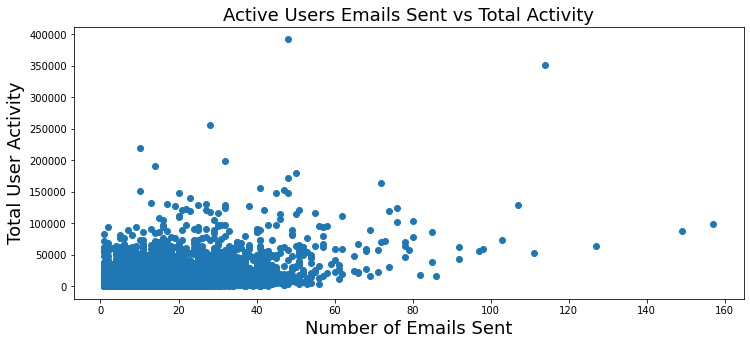

In [766]:
plt.figure(figsize=(12,5)) 
y = df_active_email_vs_total_activity["TotalUserActivity"]
x = df_active_email_vs_total_activity["EmailsSent"]

plt.scatter(x, y)
plt.ylabel("Total User Activity", fontsize=18)
plt.xlabel("Number of Emails Sent", fontsize=18)
plt.title("Active Users Emails Sent vs Total Activity", fontsize=18)
plt.show()

In [776]:
y = df_active_email_vs_total_activity["TotalUserActivity"]
x = df_active_email_vs_total_activity["EmailsSent"]
print(stats.linregress(x, y))

LinregressResult(slope=748.4076594469466, intercept=-422.23298789267665, rvalue=0.5545179012781286, pvalue=0.0, stderr=4.935528393603274, intercept_stderr=40.77664363421796)


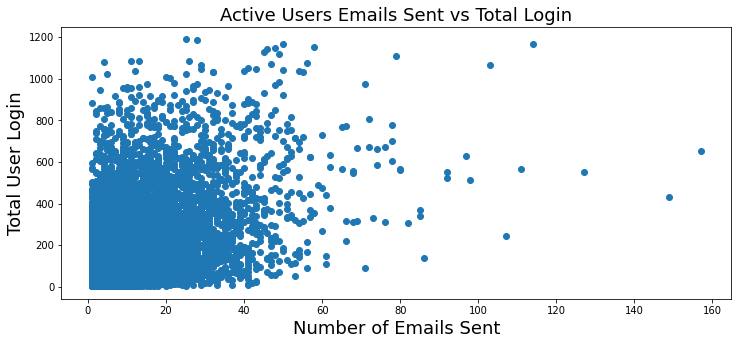

In [767]:
plt.figure(figsize=(12,5)) 
y = df_active_email_vs_total_login["TotalUserLogin"]
x = df_active_email_vs_total_login["EmailsSent"]

plt.scatter(x, y)
plt.ylabel("Total User Login", fontsize=18)
plt.xlabel("Number of Emails Sent", fontsize=18)
plt.title("Active Users Emails Sent vs Total Login", fontsize=18)
plt.show()

In [781]:
y = df_active_email_vs_total_login["TotalUserLogin"]
x = df_active_email_vs_total_login["EmailsSent"]
print(stats.linregress(x, y))

LinregressResult(slope=10.04650891940871, intercept=22.192831331334382, rvalue=0.5779407635485759, pvalue=0.0, stderr=0.062339298193728035, intercept_stderr=0.5150385417997911)


### Visualizing the relationship data, we see firstly that active users are being sent more emails. From the data, it seems like no inactive user has received over 60 emails with one outlier exception. Using regession analysis, we find that none of the scatter plots indicate any significant relationship between either variable. The very low R-squared values indicate that the emails are slightly more effective on active users. However, this data does confirm that the emails do not hold any discernable influence on inactive users. 